## Project

### Loading

In [ ]:
import pandas as pd, torch, torch.nn as nn, pickle
import math
import numpy as np
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt 




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data1 = pd.read_excel('/content/drive/MyDrive/CRISPRi/data1-2.xlsx') 
data2= pd.read_excel(open('/content/drive/MyDrive/CRISPRi/data1-2.xlsx', 'rb'), sheet_name='SetB raw reads')
data3= pd.read_excel(open('/content/drive/MyDrive/CRISPRi/data1-2.xlsx', 'rb'), sheet_name='SetA sgRNA annotations')
data4= pd.read_excel(open('/content/drive/MyDrive/CRISPRi/data1-2.xlsx', 'rb'), sheet_name='SetB sgRNA annotations')
data5 = pd.read_excel(open('/content/drive/MyDrive/CRISPRi/StartEnd.xlsx', 'rb'), sheet_name='HT29 Log-fold Change')

## Data cleaning

In [ ]:
df1 = pd.DataFrame(data1)
df3 = pd.DataFrame(data3)
df2 = pd.DataFrame(data2)
df4 = pd.DataFrame(data4)
df5 = pd.DataFrame(data5)

# Data Cleaning

df1.columns = df1.iloc[1]
df1 = df1.iloc[2:]

df2.columns = df2.iloc[0]
df2 = df2.iloc[1:]

df5.columns = df5.iloc[1]
df5 = df5.iloc[2:]
df5 = df5.drop(columns = ['Avana','Avana-Dolcetto',	'Karyotype band'])

#merge with annoted gen symbol
data1 = df1
data1['Annotated Gene Symbol'] = df3['Annotated Gene Symbol']

data2 = df2
data2['Annotated Gene Symbol'] = df4['Annotated Gene Symbol']



### First sheet data processing

In [ ]:
cols = ['RepA','RepB',	'RepC',	'RepA',	'RepB',	'RepC']

#calculate the mean
data1['mean'] = data1[cols].mean(axis=1)

data1['fold change'] = ((data1['mean']+0.0000001) / (data1['pDNA']+0.0000001)) #added small amount to mean for log when all replicates are zero

#rename cols
data1.columns = ['sgRNA Sequence',	'pDNA',	'RepAA'	,'RepBB',	'RepCC'	,'RepA',	'RepB',	'RepC',	'Annotated Gene Symbol'	,'mean',	'fold change']

# Calculate the log of the percentage mean
data1['fold change']= data1['fold change'].apply(pd.to_numeric)
data1['log fold change'] = np.log2(data1['fold change'])

#merge with the gene symbol
data1 = data1.merge(df5, left_on='Annotated Gene Symbol', right_on='Gene Symbol')

#calculate log fold change best
data1['log fold change best']  = data1.groupby(['Annotated Gene Symbol'])['log fold change'].transform(min) 

#calculate target
data1['target'] = data1['log fold change']/(data1['log fold change best'])

#### cleaning
data1= data1[data1['pDNA'] != 0]
data1=data1.replace([np.inf, -np.inf], np.nan)
data1=data1.dropna()


## remove outliers

# compute the interquartile range
q1 = data1["target"].quantile(0.25)
q3 = data1["target"].quantile(0.75)
iqr = q3 - q1

# remove rows where the value in the "target" column is outside the interquartile range
data1 = data1[(data1["target"] >= q1 - 1.5 * iqr) & (data1["target"] <= q3 + 1.5 * iqr)]


#Normalize the target
data1["target"] = (data1["target"] - data1["target"].mean()) / data1["target"].std()




<ipython-input-5-512a509e8f56>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["target"] = (data1["target"] - data1["target"].mean()) / data1["target"].std()


In [ ]:
data1

,sgRNA Sequence,pDNA,RepAA,RepBB,RepCC,RepA,RepB,RepC,Annotated Gene Symbol,mean,fold change,log fold change,Gene Symbol,Dolcetto,Chromosome,Gene start,Gene end,Lupus gene set,log fold change best,target
0,AAAAAAAAAATACTGAGAGA,503.0,264.0,231.0,275.0,483.0,608.0,337.0,GATA5,366.333333,0.728297,-0.457401,GATA5,-0.217788,20,62463497.0,62475970.0,n,-0.785819,-0.226739
1,CGGGCTGGACGACGTCTGGC,881.0,339.0,403.0,488.0,1040.0,422.0,374.0,GATA5,511.000000,0.580023,-0.785819,GATA5,-0.217788,20,62463497.0,62475970.0,n,-0.785819,1.025582
2,GCACTCACACCTGAAGCTAC,691.0,646.0,296.0,370.0,873.0,904.0,427.0,GATA5,586.000000,0.848046,-0.237785,GATA5,-0.217788,20,62463497.0,62475970.0,n,-0.785819,-1.064180
3,GGGCTGGACCGAAACCGGCG,1020.0,887.0,363.0,525.0,641.0,1080.0,396.0,GATA5,648.666667,0.635948,-0.653020,GATA5,-0.217788,20,62463497.0,62475970.0,n,-0.785819,0.519194
4,AAAAAAAAGAGGAGGGACGG,821.0,184.0,255.0,115.0,181.0,250.0,123.0,GATA6,184.666667,0.224929,-2.152459,GATA6,-0.654790,18,22169443.0,22202528.0,n,-3.107461,0.104686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53489,TTTGGCAGTAGCTGTGGCTG,1118.0,707.0,479.0,963.0,802.0,883.0,546.0,HTR1D,730.000000,0.652952,-0.614952,HTR1D,0.351027,1,23191895.0,23194729.0,n,-0.614952,1.025582
53490,TTTCAAGGGCGCCTTAGGAA,831.0,215.0,259.0,364.0,465.0,1035.0,531.0,GABRG2,478.166667,0.575411,-0.797335,GABRG2,0.111660,5,162000057.0,162162977.0,n,-0.797335,1.025582
53491,TTTCACGGATGTCGAAGTGG,1247.0,640.0,559.0,550.0,1572.0,946.0,753.0,FCGR1B,836.666667,0.670944,-0.575737,FCGR1B,0.244755,1,121087345.0,121096310.0,n,-0.575737,1.025582
53492,TTTGCTCCCAGCGACTACCC,826.0,653.0,383.0,351.0,759.0,710.0,363.0,PCDHGA6,536.500000,0.649516,-0.622564,PCDHGA6,0.406090,5,141373914.0,141512979.0,n,-0.622564,1.025582


### Second sheet data processing

In [ ]:

cols = ['RepA','RepB',	'RepC',	'RepA',	'RepB',	'RepC']
data2['mean'] = data2[cols].mean(axis=1)

data2['fold change'] = ((data2['mean']+0.0000001) / (data2['pDNA']+0.0000001)) #added small amount to mean for log when all replicates are zero

#rename cols
data2.columns = ['sgRNA Sequence',	'pDNA',	'RepAA'	,'RepBB',	'RepCC'	,'RepA',	'RepB',	'RepC',	'Annotated Gene Symbol'	,'mean',	'fold change']

# Calculate the log of the percentage mean
data2['fold change']= data2['fold change'].apply(pd.to_numeric)

data2['log fold change'] = np.log2(data2['fold change'])


data2 = data2.merge(df5, left_on='Annotated Gene Symbol', right_on='Gene Symbol')


data2['log fold change best']  = data2.groupby(['Annotated Gene Symbol'])['log fold change'].transform(min) #Jack - maybe change this to min based on his comment about best performing


data2['target'] = data2['log fold change']/(data2['log fold change best'])

#cleaning
data2= data2[data2['pDNA'] != 0]
data2=data2.replace([np.inf, -np.inf], np.nan) 
data2=data2.dropna()


# remove outliers

# compute the interquartile range
q1 = data2["target"].quantile(0.25)
q3 = data2["target"].quantile(0.75)
iqr = q3 - q1

# remove rows where the value in the "target" column is outside the interquartile range
data2 = data2[(data2["target"] >= q1 - 1.5 * iqr) & (data2["target"] <= q3 + 1.5 * iqr)]


#Normalize the target
data2["target"] = (data2["target"] - data2["target"].mean()) / data2["target"].std()



In [ ]:
data2

,sgRNA Sequence,pDNA,RepAA,RepBB,RepCC,RepA,RepB,RepC,Annotated Gene Symbol,mean,fold change,log fold change,Gene Symbol,Dolcetto,Chromosome,Gene start,Gene end,Lupus gene set,log fold change best,target
0,AAAAAAAAAGCTGTGCGCAG,417.0,433.0,474.0,340.0,445.0,270.0,498.0,MAP1LC3C,410.000000,0.983213,-0.024423,MAP1LC3C,-0.060514,1,241995490.0,241999073.0,n,-0.024423,0.316181
4,AAAGGAACAAGATGAGGAGA,639.0,763.0,892.0,698.0,960.0,427.0,316.0,LRRC70,676.000000,1.057903,0.081207,LRRC70,-0.035814,5,62578735.0,62581448.0,n,0.081207,0.316181
6,AAAAAAAAGTGGTGGGGTGG,986.0,1108.0,1014.0,772.0,1474.0,628.0,492.0,LRRC19,914.666667,0.927654,-0.108342,LRRC19,0.077435,9,26993136.0,27005693.0,n,-0.108342,0.316181
9,AAAAAAAGAAAGAAACACAA,302.0,410.0,579.0,246.0,483.0,357.0,405.0,HMGA1,413.333333,1.368653,0.452757,HMGA1,-0.093776,6,34236873.0,34246231.0,n,0.290677,0.883949
10,ATAGTTTAGGGCTGACTCCA,829.0,1142.0,1113.0,717.0,1491.0,910.0,889.0,HMGA1,1043.666667,1.258947,0.332217,HMGA1,-0.093776,6,34236873.0,34246231.0,n,0.290677,0.461695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54513,TTCTAATCCAGATGTGCGCC,1685.0,2639.0,2394.0,1788.0,2418.0,1963.0,1699.0,NPVF,2150.166667,1.276063,0.351700,NPVF,0.254366,7,25224570.0,25228486.0,n,-0.268805,-2.034319
54514,TTTACAAAACCTGCCGCCCT,1322.0,2432.0,1758.0,1915.0,2140.0,1723.0,1205.0,NPVF,1862.166667,1.408598,0.494260,NPVF,0.254366,7,25224570.0,25228486.0,n,-0.268805,-2.574343
54515,TTTCTCCTCGGGGTCGGAGC,1002.0,881.0,959.0,822.0,718.0,925.0,685.0,NPVF,831.666667,0.830007,-0.268805,NPVF,0.254366,7,25224570.0,25228486.0,n,-0.268805,0.316181
54516,TTGCAGTCCTTGCAGGAGGC,1276.0,1702.0,1867.0,1220.0,1803.0,1945.0,1324.0,PCDH11Y,1643.500000,1.288009,0.365143,PCDH11Y,0.083796,Y,5000226.0,5742224.0,n,0.365143,0.316181


## Final df

In [ ]:
#Code to merge data1 and data2 spreadsheets.

#data1 = data1.loc[~data1.index.duplicated(keep='first')]
#data2 = data2.loc[~data2.index.duplicated(keep='first')]

# Put the two files together
#frames = [data1, data2]

#df = pd.concat(frames,axis=0)

In [ ]:
#We only use data1 spreadsheet due to excessive noise in data2 spreadsheet.
df = data1

## Include Genome position

In [ ]:
import pandas as pd
DATADIR = "/content/drive/My Drive/ML4fungen/Assignment 2/" # might need to change this
binding_data = pd.read_csv(DATADIR + "ENCFF300IYQ.bed.gz", sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data[:10]

,chrom,start,end,name,score,strand
3417,chr1,714156,714372,.,1000,.
28093,chr1,805243,805372,.,1000,.
32029,chr1,840059,840248,.,1000,.
17195,chr1,848298,848514,.,1000,.
6610,chr1,855056,855272,.,1000,.
10598,chr1,856479,856695,.,1000,.
15904,chr1,858493,858709,.,1000,.
16616,chr1,860345,860561,.,1000,.
10818,chr1,860967,861183,.,1000,.
31703,chr1,873565,873753,.,1000,.


In [ ]:
import pickle
genome = pickle.load(open(DATADIR+"hg38.pkl","rb")) 
#genome = pickle.load(open(DATADIR+"hg19.pickle","rb"))

In [ ]:

posA = pd.read_csv(('/content/drive/MyDrive/CRISPRi/setA.tsv'), sep='\t')
posB = pd.read_csv(('/content/drive/MyDrive/CRISPRi/setB.tsv'), sep='\t')


df_mergedA = df.merge(posA, on='sgRNA Sequence')
df_mergedB = df.merge(posB, on='sgRNA Sequence')

# Put the two files together
frames = [df_mergedA,df_mergedB]
result = pd.concat(frames,axis=0)

#clean
df_cleaned = result.dropna()

In [ ]:
#only keep one associated genomic position
df_cleaned["genomic_pos"] = df_cleaned["genomic_pos"].str.split(";").str[0]

<ipython-input-45-eaa9d566e37a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["genomic_pos"] = df_cleaned["genomic_pos"].str.split(";").str[0]


In [ ]:
def extract_numeric_position(position):

    chromosome, pos = position.rsplit(":", 1)

    numeric_pos = int(pos)

    return chromosome, numeric_pos


# apply the extract_numeric_position function to each row of the dataframe
df_cleaned["chromosome"] = df_cleaned["genomic_pos"].apply(extract_numeric_position).apply(lambda x: x[0])
df_cleaned["numeric_position"] = df_cleaned["genomic_pos"].apply(extract_numeric_position).apply(lambda x: x[1])


# print the resulting dataframe

df_cleaned

<ipython-input-46-6abf047aa1a4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["chromosome"] = df_cleaned["genomic_pos"].apply(extract_numeric_position).apply(lambda x: x[0])
<ipython-input-46-6abf047aa1a4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["numeric_position"] = df_cleaned["genomic_pos"].apply(extract_numeric_position).apply(lambda x: x[1])


,sgRNA Sequence,pDNA,RepAA,RepBB,RepCC,RepA,RepB,RepC,Annotated Gene Symbol_x,mean,...,Gene start,Gene end,Lupus gene set,log fold change best,target,Annotated Gene Symbol_y,Annotated Gene ID,genomic_pos,chromosome,numeric_position
0,AAAAAAAAAATACTGAGAGA,503.0,264.0,231.0,275.0,483.0,608.0,337.0,GATA5,366.333333,...,62463497.0,62475970.0,n,-0.785819,-0.226739,GATA3,2625,chr3:135510846,chr3,135510846
2,GCACTCACACCTGAAGCTAC,691.0,646.0,296.0,370.0,873.0,904.0,427.0,GATA5,586.000000,...,62463497.0,62475970.0,n,-0.785819,-1.064180,PRAMEF2,65122,chr1:12857076,chr1,12857076
4,AAAAAAAAGAGGAGGGACGG,821.0,184.0,255.0,115.0,181.0,250.0,123.0,GATA6,184.666667,...,22169443.0,22202528.0,n,-3.107461,0.104686,ANKH,56172,chr5:14871700,chr5,14871700
5,CAGGCGCGCCTCCTGCCCCG,1161.0,301.0,540.0,411.0,611.0,371.0,344.0,GATA6,429.666667,...,22169443.0,22202528.0,n,-3.107461,-0.588039,NKAIN1,79570,chr1:31239799,chr1,31239799
8,AACGAGTCAGGCATCGTGGT,781.0,484.0,616.0,402.0,700.0,945.0,517.0,CNPPD1,610.666667,...,219171897.0,219178106.0,n,-0.734752,-0.523387,ZSCAN5A,79149,chr19:56314754,chr19,56314754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53003,TTGGACAGAAACAACTGGTA,897.0,410.0,386.0,565.0,816.0,833.0,414.0,SCNN1G,570.666667,...,23182715.0,23216883.0,n,-0.801244,0.469159,ARL14EPL,644100,chr5:116051544,chr5,116051544
53004,TTTCGGTAACTTCCGGGCCC,589.0,349.0,173.0,412.0,532.0,381.0,181.0,SCNN1G,338.000000,...,23182715.0,23216883.0,n,-0.801244,1.025582,KRTCAP3,200634,chr2:27442435,chr2,27442435
53006,TTTGGCAGTAGCTGTGGCTG,1118.0,707.0,479.0,963.0,802.0,883.0,546.0,HTR1D,730.000000,...,23191895.0,23194729.0,n,-0.614952,1.025582,CCDC117,150275,chr22:28772764,chr22,28772764
53008,TTTCACGGATGTCGAAGTGG,1247.0,640.0,559.0,550.0,1572.0,946.0,753.0,FCGR1B,836.666667,...,121087345.0,121096310.0,n,-0.575737,1.025582,LOC79999,79999,chr17:19219415,chr17,19219415


## checks

In [ ]:
# For sanity check that Professor Knowles described in his interim report comments. Dataframe for LFC of non-targeting guides

df_NonTarget = df.loc[df['Annotated Gene Symbol'] == 'CONTROL']
df_NonTarget

,sgRNA Sequence,pDNA,RepAA,RepBB,RepCC,RepA,RepB,RepC,Annotated Gene Symbol,mean,fold change,log fold change,Gene Symbol,Dolcetto,Chromosome,Gene start,Gene end,Lupus gene set,log fold change best,target


### Data Vizualisation



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


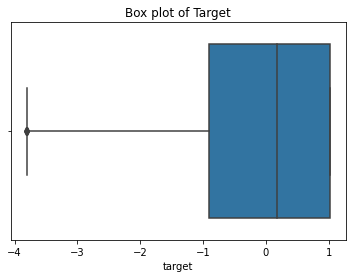

In [ ]:

plt.title("Box plot of Target")
sns.boxplot(df["target"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


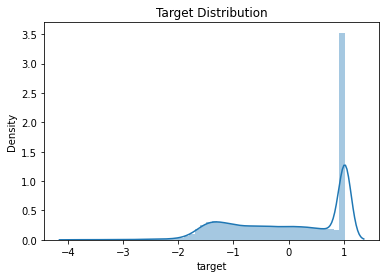

In [ ]:
plt.title("Target Distribution")
sns.distplot(df["target"])


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


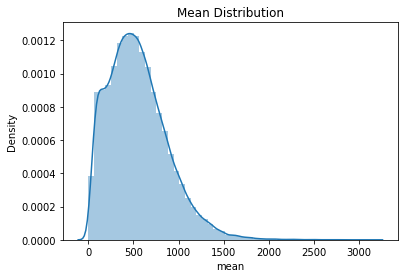

In [ ]:
plt.title("Mean Distribution")
sns.distplot(df["mean"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


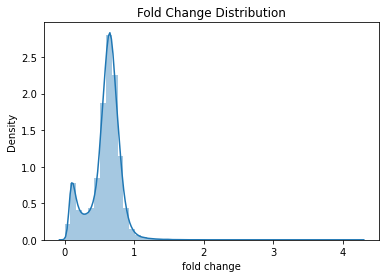

In [ ]:
plt.title("Fold Change Distribution")
sns.distplot(df["fold change"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


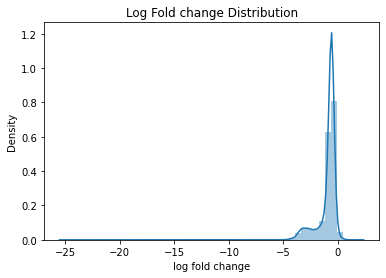

In [ ]:

plt.title("Log Fold change Distribution")
sns.distplot(df["log fold change"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


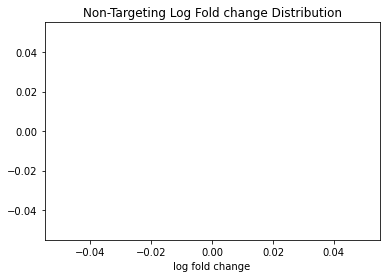

In [ ]:
# Added this based on the sanity check that Professor Knowles mentioned in the interim report comments.
plt.title("Non-Targeting Log Fold change Distribution")
sns.distplot(df_NonTarget["log fold change"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


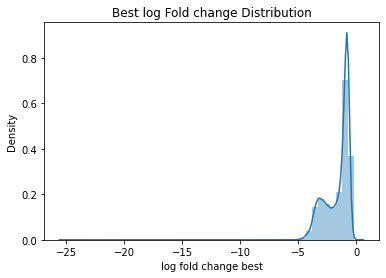

In [ ]:

plt.title("Best log Fold change Distribution")
sns.distplot(df["log fold change best"])

### Dataloading

In [ ]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
import pandas as pd
import tensorflow as tf

import torch
import torch.nn as nn
import torch.utils.data
#assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"

print("Torch version:", torch.__version__)

import torch
from torch.autograd import Variable
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Torch version: 1.13.0+cu116


In [ ]:
%%cython

import numpy as np
np.get_include() 
cimport cython
cimport numpy as np


cdef dict bases={ 'A':<int>0, 'C':<int>1, 'G':<int>2, 'T':<int>3 ,'a':<int>4, 'c':<int>5, 'g':<int>6, 't':<int>7} 

@cython.boundscheck(False)
def one_hot( str string ):
    cdef np.ndarray[np.float32_t, ndim=2] res = np.zeros( (8,len(string)), dtype=np.float32 )
    cdef int j
    for j in range(len(string)):
        if string[j] in bases: 
            res[ bases[ string[j] ], j ]=float(1.0)
    return(res)


In [ ]:
df = df_cleaned.loc[:, ["sgRNA Sequence", 'numeric_position', 'chromosome', 'target']]
df = df.rename(columns={"sgRNA Sequence": "sgRNA_Sequence"})
df

,sgRNA_Sequence,numeric_position,chromosome,target
0,AAAAAAAAAATACTGAGAGA,135510846,chr3,-0.226739
2,GCACTCACACCTGAAGCTAC,12857076,chr1,-1.064180
4,AAAAAAAAGAGGAGGGACGG,14871700,chr5,0.104686
5,CAGGCGCGCCTCCTGCCCCG,31239799,chr1,-0.588039
8,AACGAGTCAGGCATCGTGGT,56314754,chr19,-0.523387
...,...,...,...,...
53003,TTGGACAGAAACAACTGGTA,116051544,chr5,0.469159
53004,TTTCGGTAACTTCCGGGCCC,27442435,chr2,1.025582
53006,TTTGGCAGTAGCTGTGGCTG,28772764,chr22,1.025582
53008,TTTCACGGATGTCGAAGTGG,19219415,chr17,1.025582


In [ ]:
##try for one
 
full_seq_from_genome = genome['chr3'][135510846-50:135510846+70].lower()
seq_before = genome['chr3'][135510846-50:135510846].lower()
seq_after = genome['chr3'][135510846+20:135510846+70].lower()
 
sequence = seq_before + 'AAAAAAAAAATACTGAGAGA'   + seq_after
enc = one_hot(sequence)

print(sequence)


cttaggaataaatctcacagaagatgtgaaagacctatacaattaaaactAAAAAAAAAATACTGAGAGAaattaaagataacctaattaaatagagtgatacactgtgttgatgaaaca


In [ ]:
# Train test split

X= df
y= df['target']

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

class BedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, data_set):
        super(BedPeaksDataset, self).__init__()
        self.atac_data = data_set
        

    def __iter__(self): 
        
        for i,row in enumerate(self.atac_data.itertuples()):
            seq = row.sgRNA_Sequence
            pos = row.numeric_position
            chrom = row.chromosome
        
            seq_before = genome[chrom][pos-75:pos].lower()
            seq_after = genome[chrom][pos+20:pos+95].lower()

            sequence = seq_before + row.sgRNA_Sequence + seq_after
    

            y_target = row.target
            value = np.float32(1)
          
            yield((one_hot(sequence), value),y_target)

            

    def __len__(self):
        return len(self.atac_data)

train_dataset = BedPeaksDataset(X_dev)
test_dataset = BedPeaksDataset(X_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=1000, num_workers = 0)



In [ ]:
s=iter(test_dataloader)
l=next(s)
l[0][0].shape


torch.Size([1000, 8, 220])

In [ ]:
print(len(train_dataloader))
print(len(test_dataloader))

21
6


Hey Elia! see below, when we normalize y all of the y values are being squeezed into a very narrow range. All near 0.237, is this what we did when the CNN was working the first time? We may need to change how we normalize. I think this is why the loss is always almost zero.

Also, I think this has something to do with why our accuracy is weird negative numbers (see link below).

https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean

In [ ]:
for (x,y) in (test_dataloader):

  print(x[0].shape) 
  print(x[1].shape)
  print(y.shape)
  break

torch.Size([1000, 8, 220])
torch.Size([1000])
torch.Size([1000])


### Network

In [ ]:
import torch.nn.functional as F

In [ ]:
class CNN_1d(nn.Module):

    def __init__(self, 
                 n_output_channels = 1, 
                 filter_widths = [11, 3], 
                 max_pool_factor = 4, 
                 nchannels = [8, 32, 32],
                 n_hidden = 32, 
                 dropout = 0.2):
        
        super(CNN_1d, self).__init__()
       
        conv_layers = []
        for i in range(len(nchannels)-1):
            #print(int((filter_widths[i]-1)/2))
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding = int((filter_widths[i]-1)/2)),  
                        nn.BatchNorm1d(nchannels[i+1]), # tends to help give faster convergence: https://arxiv.org/abs/1502.03167
                        nn.Dropout1d(dropout), # popular form of regularization: https://jmlr.org/papers/v15/srivastava14a.html
                        nn.MaxPool1d(max_pool_factor), 
                        nn.ELU(inplace=True)  ] # popular alternative to ReLU: https://arxiv.org/abs/1511.07289
            assert(filter_widths[i] % 2 == 1) # assume this
           

        # If you have a model with lots of layers, you can create a list first and 
        # then use the * operator to expand the list into positional arguments, like this:
        self.conv_net = nn.Sequential(*conv_layers)

        
        self.dense_net = nn.Sequential( nn.Linear(320, n_hidden),  
                                        nn.Dropout(dropout),
                                        nn.ELU(inplace=True), 
                                        nn.Linear(n_hidden, n_output_channels) )

    def forward(self, x):
        net = self.conv_net(x)
        net = net.view(net.size(0), -1)
        net = self.dense_net(net)
        return(net)

cnn_1d = CNN_1d()

#print("Input length:", cnn_1d.seq_len)

cnn_1d

CNN_1d(
  (conv_net): Sequential(
    (0): Conv1d(8, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout1d(p=0.2, inplace=False)
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): ELU(alpha=1.0, inplace=True)
  )
  (dense_net): Sequential(
    (0): Linear(in_features=320, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
cnn_1d =  CNN_1d() 

### Actual training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats 

In [ ]:
def run_one_epoch(train_flag, dataloader, cnn_1d, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval() 
    cnn_1d.to(device)

    losses = []
    accuracies = []
    returned_output = [] # Addition for pearson p-value
    returned_y_target = [] # Addition for pearson p-value

    for (x,y) in (dataloader): # collection of tuples with iterator

        x_rna = x[0] # (bs, L, longueur)
        y_target = y.float() #(bs, 1)
        returned_y_target.append(y_target.detach().cpu().numpy()) # Addition for pearson p-value
        
        (x_rna, y_target) = ( x_rna.to(device), y_target.to(device) ) # transfer data to GPU

        output = cnn_1d(x_rna) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        returned_output.append(output.detach().cpu().numpy()) # Addition for pearson p-value
        mse = nn.MSELoss()
        loss = mse(output, y_target)
        

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
    
        R2 = r2_score(y_target.detach().cpu().numpy(), output.detach().cpu().numpy())
        accuracies.append(R2) 

    returned_output = np.concatenate(returned_output) # Addition for pearson p-value
    returned_y_target = np.concatenate(returned_y_target) # Addition for pearson p-value
    pearson_pvalue = stats.pearsonr(returned_y_target, returned_output) # Addition for pearson p-value
    #plt.title("Target vs. Output")
    #plt.scatter(returned_y_target, returned_output)
    #plt.show()


    return( np.mean(losses), np.mean(accuracies), pearson_pvalue[1]) # Additions
    #return(accuracies)

In [ ]:
#x, y = run_one_epoch(True, train_dataloader, cnn_1d, torch.optim.Adam(cnn_1d.parameters(), amsgrad=True, lr=0.001))
#plt.title("target vs output scatter")
#plt.scatter( x,y)
#run_one_epoch(True, train_dataloader, cnn_1d, torch.optim.Adam(cnn_1d.parameters(), amsgrad=True, lr=0.001))

In [ ]:
import timeit

def train_model(cnn_1d, train_dataloader, test_dataloader, epochs=100, patience=10, verbose=True, batch_size=1000):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d.to(device)

    # 2. Instantiates an optimizer for the model. 

    optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True, lr=0.001)

    # 3. Run the training loop with early stopping. 

    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf
    best_val_acc, best_train_acc = 0, 0

    check_point_filename = 'cnn_1d_checkpoint.pt' # to save the best model fit to date
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc, train_pearson_pvalue = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device) # Adjusted for pearson p-value
        val_loss, val_acc, val_pearson_pvalue = run_one_epoch(False, test_dataloader, cnn_1d, optimizer, device) # Adjusted for pearson p-value
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if val_loss < best_val_loss: 
            torch.save(cnn_1d.state_dict(), check_point_filename)
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_train_acc = train_acc
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                cnn_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        
        if verbose:
            print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f pvalue: %.4f. Val loss: %.4f acc: %.4f pvalue: %.4f. Patience left: %i" % 
              (epoch+1, elapsed, train_loss, train_acc, train_pearson_pvalue, val_loss, val_acc, val_pearson_pvalue, patience_counter ))    # Adjusted for pearson p-value

    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    # TODO CODE
    return(cnn_1d, best_train_acc, best_val_acc)
    #return(cnn_1d, train_acc, val_acc)

In [ ]:
train_model(cnn_1d, train_dataloader, test_dataloader, epochs=100, patience=10, verbose=True, batch_size=1000)

Epoch 1 took 1.23s. Train loss: 1.0449 acc: -0.0444 pvalue: 0.0000. Val loss: 0.9951 acc: 0.0030 pvalue: 0.0000. Patience left: 10
Epoch 2 took 1.27s. Train loss: 1.0125 acc: -0.0118 pvalue: 0.0000. Val loss: 0.9841 acc: 0.0141 pvalue: 0.0000. Patience left: 10
Epoch 3 took 1.25s. Train loss: 1.0031 acc: -0.0024 pvalue: 0.0000. Val loss: 0.9809 acc: 0.0173 pvalue: 0.0000. Patience left: 10
Epoch 4 took 1.27s. Train loss: 0.9926 acc: 0.0080 pvalue: 0.0000. Val loss: 0.9779 acc: 0.0203 pvalue: 0.0000. Patience left: 10
Epoch 5 took 1.25s. Train loss: 0.9832 acc: 0.0173 pvalue: 0.0000. Val loss: 0.9770 acc: 0.0212 pvalue: 0.0000. Patience left: 10
Epoch 6 took 1.28s. Train loss: 0.9775 acc: 0.0231 pvalue: 0.0000. Val loss: 0.9735 acc: 0.0247 pvalue: 0.0000. Patience left: 10
Epoch 7 took 1.25s. Train loss: 0.9686 acc: 0.0318 pvalue: 0.0000. Val loss: 0.9745 acc: 0.0237 pvalue: 0.0000. Patience left: 9
Epoch 8 took 1.27s. Train loss: 0.9630 acc: 0.0376 pvalue: 0.0000. Val loss: 0.9753 acc:

(CNN_1d(
   (conv_net): Sequential(
     (0): Conv1d(8, 32, kernel_size=(11,), stride=(1,), padding=(5,))
     (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): Dropout1d(p=0.2, inplace=False)
     (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
     (4): ELU(alpha=1.0, inplace=True)
     (5): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
     (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): Dropout1d(p=0.2, inplace=False)
     (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
     (9): ELU(alpha=1.0, inplace=True)
   )
   (dense_net): Sequential(
     (0): Linear(in_features=320, out_features=32, bias=True)
     (1): Dropout(p=0.2, inplace=False)
     (2): ELU(alpha=1.0, inplace=True)
     (3): Linear(in_features=32, out_features=1, bias=True)
   )
 ), 0.0764352594444279, 0.028167407847216164)